In [1]:
import numpy
import scipy
import nmrglue
import pylab
import os
from scipy import fftpack

from __future__ import print_function
%matplotlib inline

###  READ IN DATA USING NMRGLUE

In [2]:
expt_no = "3"

gamma = 4258.0    # Hz/G 19F
gradient = 190.0  # G/cm
bigDelta  =1.0    # seconds

directory = os.path.join(  "..", "bruker_data", "qspace_foam")

file_rrr = os.path.join( directory, expt_no, "pdata", "1")

file_ser = os.path.join(directory,expt_no)

vd_file  = os.path.join(directory, expt_no, "vdlist")

In [3]:
pinfo,expt = nmrglue.bruker.read_pdata( file_rrr )
info,expt_fid = nmrglue.bruker.read( file_ser )
fid_B = abs(expt_fid)
print( fid_B.shape )

npts = info['acqus']['L'][12]
nloops = info['acqus']['L'][13]
phc0 = -pinfo['procs']['PHC0']
phc1 = -pinfo['procs']['PHC1']



print("npts,nloops,phc0,phc1",npts,nloops,phc0,phc1)

(32L, 16384L)
npts,nloops,phc0,phc1 50 320 0 0


Z:\Documents\Continuum\Anaconda2\lib\site-packages\nmrglue\fileio\bruker.py:299: UserWarning: Error reading the pulse program
  warn('Error reading the pulse program')
Z:\Documents\Continuum\Anaconda2\lib\site-packages\nmrglue\fileio\bruker.py:996: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return dic, data.reshape(shape)


### Display first few echoes of first FID

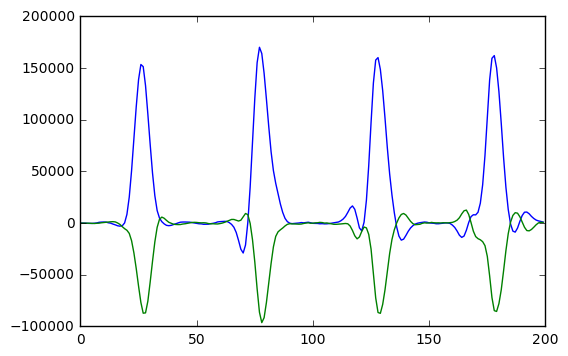

In [4]:
pylab.plot( expt_fid[0][:200].real);
pylab.plot( expt_fid[0][:200].imag);

###  Maximize FID in one channel by using zero order phasing 

theta_opt, s_real_opt, s_imag_opt 27.0 334721374.318 -393037.525857


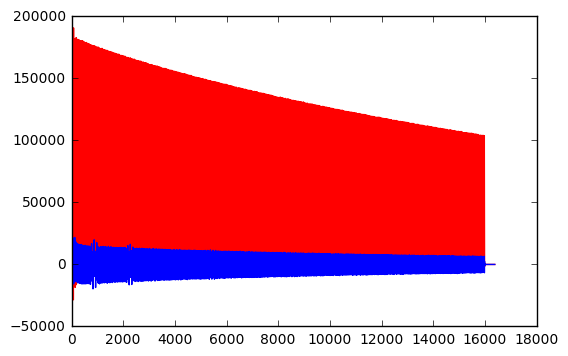

In [5]:
fid = expt_fid[0]


s_real_opt = (fid.real).sum()
s_imag_opt = (fid.imag).sum()
theta_opt = 0
for theta in range(1,360):
    fid1 = nmrglue.process.proc_base.ps(fid,theta,0)
    
    s_real = (fid1.real).sum()
    s_imag = (fid1.imag).sum()
    
    if s_real > s_real_opt :
        theta_opt = 1.0*theta
        s_real_opt = 1.0*s_real
        s_imag_opt = 1.0*s_imag
        
print( "theta_opt, s_real_opt, s_imag_opt", theta_opt, s_real_opt, s_imag_opt)




fid1 = nmrglue.process.proc_base.ps(fid,theta_opt,0)
pylab.plot( fid1[:].real, 'r');
pylab.plot( fid1[:].imag);

In [6]:
fid1 = nmrglue.process.proc_base.ps(expt_fid,theta_opt,0)
#fid1 = nmrglue.process.proc_base.ps(fid_chop,theta_opt,0)

In [7]:
fid1 =fid1.real

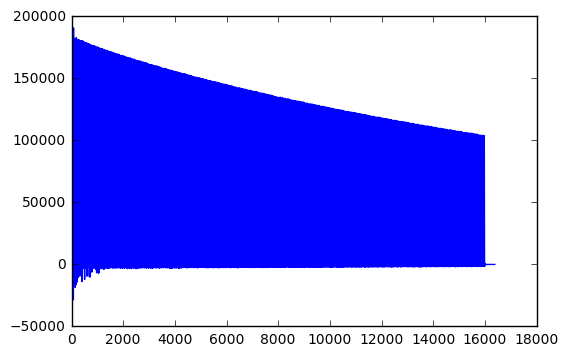

In [8]:
pylab.plot(fid1[0]);

### Read in $\delta$ values from vdlist

In [9]:
fp =open(vd_file,'r')
vdlist = fp.read()
fp.close()


print( type(vdlist) )

vdlist_str =(vdlist.replace('\n', "" )).split('u')
print( vdlist_str )

vdlist1 = []
for s in vdlist_str[:]:
    try:
        vdlist1.append(float(s))
    except:
        pass

    
vdlist = scipy.array(vdlist1)
print( vdlist, len(vdlist))

<type 'str'>
['25', '37', '50', '62', '75', '87', '100', '113', '125', '137', '150', '162', '175', '187', '200', '212', '225', '237', '250', '262', '275', '287', '300', '312', '325', '337', '350', '362', '375', '387', '400', '425', '']
[  25.   37.   50.   62.   75.   87.  100.  113.  125.  137.  150.  162.
  175.  187.  200.  212.  225.  237.  250.  262.  275.  287.  300.  312.
  325.  337.  350.  362.  375.  387.  400.  425.] 32


### Find Echo maximum position

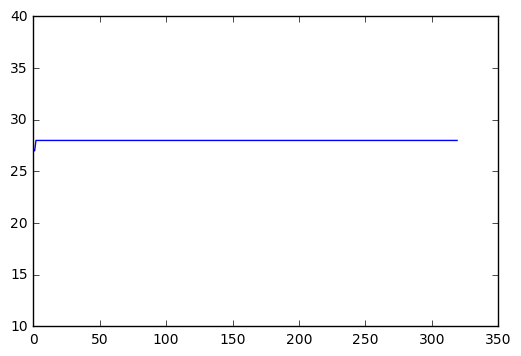

In [10]:
fid_chop = fid1[0][:nloops*npts]
fid_chop = fid_chop.reshape((nloops,npts));
mmm = fid_chop.argmax(axis=1)

pylab.plot(mmm);
pylab.ylim(10,40);

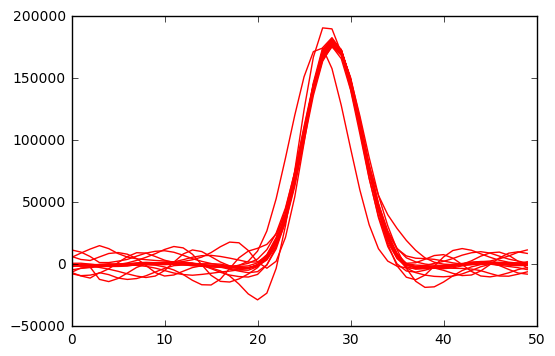

In [11]:
for i in range(20):
    pylab.plot(fid_chop[i],'r');

### Process data using full echo train and compare to just using one echo

m_opt 27


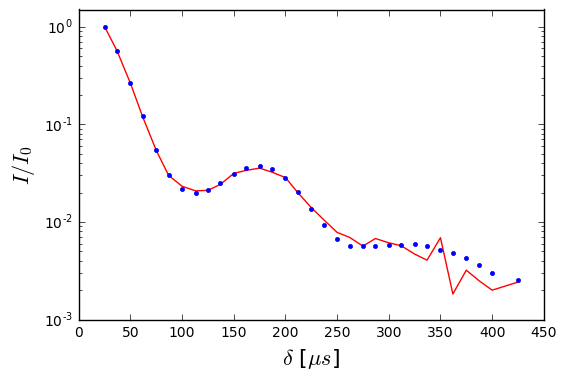

In [21]:
fid_chop = fid1[2][:nloops*npts]
fid_chop = fid_chop.reshape((nloops,npts));
mmm = fid_chop.argmax(axis=1)

m_opt = int(mmm.mean())

print("m_opt",m_opt)

data = []
for fid in fid1:
    fid_chop = fid[:nloops*npts]
    fid_chop = fid_chop.reshape((nloops,npts));
    fid_chop = fid_chop[:,m_opt-1:m_opt+0]  # sum only 1 point at top of the echo


    data.append(fid_chop[20:21].sum())  # Sum only one echo starting from 20th echo

data1 = scipy.array(data)
pylab.semilogy((vdlist),data1/data1[0],'r');


data = []
for fid in fid1:
    fid_chop = fid[:nloops*npts]
    fid_chop = fid_chop.reshape((nloops,npts));
#    fid_chop = fid_chop[:,m_opt-5:m_opt+5]
    fid_chop = fid_chop[:,m_opt-8:m_opt+8] # sum 15-16 points at the top of the echo


    data.append(fid_chop[20:].sum())  # Sum all echoes starting from 20th echo

data1 = scipy.array(data)
pylab.semilogy((vdlist),data1/data1[0], 'b.');
pylab.xlabel('$\delta$ [$\mu s$]',fontsize=16);
pylab.ylabel( '$I/I_0$' ,fontsize=16);
pylab.ylim(1e-3,1.5);